<a href="https://colab.research.google.com/github/svscsantosh/Automated-Shopping-Cart/blob/kuntal/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras import backend, models, layers, optimizers
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
from tensorflow.keras.models import Model
np.random.seed(42)

In [5]:
#!pip install tensorflow==2.8

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
filename = "/content/drive/MyDrive/dataset.zip"
with zipfile.ZipFile(filename, 'r') as zipp:
  zipp.extractall()
  zipp.close()

In [8]:
# Specify the base directory where images are located.
base_dir = '/content/dataset'
# Specify the traning, validation, and test dirrectories.  
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')


# Normalize the pixels in the train data images, resize and augment the data.
train_datagen = ImageDataGenerator(
    rescale=1./255,# The image augmentaion function in Keras
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True) # Flip image horizontally 

val_datagen = ImageDataGenerator(rescale=1./255)

# Normalize the test data imagees, resize them but don't augment them
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Found 24934 images belonging to 30 classes.
Found 6084 images belonging to 30 classes.


In [9]:
test_dir

'/content/dataset/test'

In [10]:
# Load InceptionV3 library
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Always clear the backend before training a model
backend.clear_session()
# InceptionV3 model and use the weights from imagenet
conv_base = InceptionV3(weights = 'imagenet', #Useing the inception_v3 CNN that was trained on ImageNet data.  
                  include_top = False)

87924736/87910968 [==============================] - 2s 0us/step


In [11]:
# Connect the InceptionV3 output to the fully connected layers
InceptionV3_model = conv_base.output
pool = GlobalAveragePooling2D()(InceptionV3_model)
dense_1 = layers.Dense(512, activation = 'relu')(pool)
output = layers.Dense(30, activation = 'softmax')(dense_1)

In [12]:
# Create an example of the Archictecture to plot on a graph
model_example = models.Model(inputs=conv_base.input, outputs=output)
# plot graph
#plot_model(model_example)

In [13]:
# Define/Create the model for training
model_InceptionV3 = models.Model(inputs=conv_base.input, outputs=output)
# Compile the model with categorical crossentropy for the loss function and SGD for the optimizer with the learning
# rate at 1e-4 and momentum at 0.9
model_InceptionV3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15572881310390138798
xla_global_id: -1
]


In [103]:
# Execute the model with fit_generator within the while loop utilizing the discovered GPU
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history = model_InceptionV3.fit_generator(
        train_generator,
        epochs=5,
        validation_data=test_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
   2/1559 [..............................] - ETA: 3:00:37 - loss: 0.2505 - accuracy: 0.9375

KeyboardInterrupt: ignored

In [ ]:
# Create a dictionary of the model history 
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)
# Plot the training/validation loss
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot the training/validation accuracy
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Evaluate the test accuracy and test loss of the model
test_loss, test_acc = model_InceptionV3.evaluate_generator(test_generator)
print('Model testing accuracy/testing loss:', test_acc, " ", test_loss)

In [32]:
#  SAVE THE MODEL
#model_InceptionV3.save('/content/drive/MyDrive/InceptionV3_5epochs')
# LOAD THE MODEL
model_InceptionV3 = tf.keras.models.load_model('/content/drive/MyDrive/InceptionV3_5epochs')

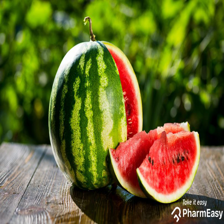

In [100]:
im1 = Image.open('/content/8.jpg')
im1 = im1.resize((224,224))
im1

In [101]:
x_test = np.array(im1)
x_test = x_test/255

In [72]:
idx_to_name = {x:i for (x,i) in enumerate(train_generator.class_indices)}

def predict(img):
    to_predict = np.zeros(shape=train_generator[0][0].shape)
    to_predict[0] = img
    print(model_InceptionV3(to_predict)[0],np.argmax(model_InceptionV3(to_predict)[0]))
    return idx_to_name[np.argmax(model_InceptionV3(to_predict)[0])]

In [102]:
predict(x_test)

tf.Tensor(
[4.6841596e-05 9.9038050e-05 6.1509141e-05 2.8038872e-05 6.9388234e-06
 1.5777598e-05 2.4146329e-06 5.6983872e-06 1.5043204e-05 1.4576112e-06
 1.2308329e-05 1.3276076e-05 7.2728299e-06 4.2622410e-06 5.0018807e-06
 9.5398636e-06 8.1168573e-06 3.5359917e-05 1.0571885e-06 1.9911256e-06
 3.9578157e-05 5.6794743e-06 4.0909185e-04 2.5303666e-03 1.1489262e-04
 3.4635820e-04 6.2007971e-06 1.2272585e-06 2.3948462e-04 9.9592614e-01], shape=(30,), dtype=float32) 29


'watermelon'

In [41]:
idx_to_name

{0: 'Apple',
 1: 'Bean',
 2: 'Bitter_Gourd',
 3: 'Bottle_Gourd',
 4: 'Brinjal',
 5: 'Broccoli',
 6: 'Cabbage',
 7: 'Capsicum',
 8: 'Carrot',
 9: 'Cauliflower',
 10: 'Cucumber',
 11: 'Papaya',
 12: 'Pineapple',
 13: 'Potato',
 14: 'Pumpkin',
 15: 'Radish',
 16: 'Tomato',
 17: 'banana',
 18: 'custard_apple',
 19: 'fig',
 20: 'grape',
 21: 'jackfruit',
 22: 'lemon',
 23: 'mango',
 24: 'onion',
 25: 'orange',
 26: 'pear',
 27: 'peas',
 28: 'strawberry',
 29: 'watermelon'}